# SPACEL workflow (2/3): Identification of spatial domain by Splane on mouse brain ST dataset

July 2023

Dataset: 75 ST slices of mouse brain ([here](https://zenodo.org/record/8167488))

In [1]:
import pandas as pd
import scanpy as sc
import anndata
import numpy as np
import sys
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [2]:
import SPACEL
from SPACEL import Splane

## Spatial transcriptomic data import

The input data type of Splane is a list of anndata objects for each slice from Spoint. If users use cell type composition from other deconvoluiton methods, the anndata objects of each slice must contain cell type composition in ``.obs`` and cell types name in ``.uns['celltypes']``

In [3]:
adata = sc.read('../data/ST_mouse_brain/mouse_brain_st.h5ad')

Plot in 2D according to the original brain region annotations. 'Undefined areas' are colored in white.

In [4]:
color15 = ['#EEEE7C', '#8ECD82', '#F99A86', '#82C748', '#E7422F', '#118165', '#C975B2', '#98D2BC', '#8498CE', '#30B743', '#99D5F6', '#F46F7F', 'white','#CDCDCC', '#ABABAB']

In [5]:
adata_list = []
for i in range(75):
    adata_list.append(adata[adata.obs['slice']==i])
    adata_list[i].uns['ABA_parent_colors'] = pd.Series(np.unique(adata_list[i].obs.ABA_parent)).replace(dict(zip(np.unique(adata.obs.ABA_parent),color15))).values.flatten()

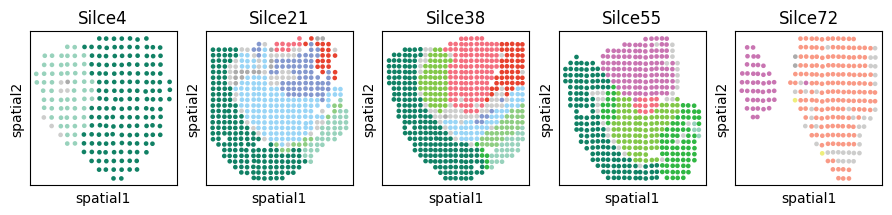

In [6]:
plt.figure(figsize=(11,2))
k=1
for i in [ 3, 20, 37, 54, 71]:
    ax = plt.subplot(1,5,k)
    sc.pl.embedding(adata_list[i], basis='spatial', color='ABA_parent', s=45, ax=ax, show=False,legend_loc=False)
    plt.title(f'Silce{i+1}')
    k+=1

## Training Splane model

In this step, we initialize the Splane model by ``Splane.init_model(...)`` using the anndata object list as input. The ``n_clusters`` parameter determines the number of spatial domains to be identified. The ``k`` parameter controls the degree of neighbors considered in the model, with a larger ``k`` value resulting in more emphasis on global structure rather than local structure. The ``gnn_dropout`` parameter influences the level of smoothness in the model’s predictions, with a higher ``gnn_dropout`` value resulting in a smoother output that accommodates the sparsity of the spatial transcriptomics data. 

We train the model by ``splane.train(...)`` to obtain latent feature of each spots/cells. The parameter ``d_l`` affects the level of batch effect correction between slices. By default, ``d_l`` is ``0.2`` for spatial transcriptomics data with single cell resolution.

Then, we can identify the spatial domain to which each spot/cell belongs by ``splane.identify_spatial_domain(...)``. By default, the results will be saved in ``spatial_domain`` column in ``.obs``. If the key parameter is provided, the results will be saved in ``.obs[key]``.

In [7]:
splane_model = Splane.init_model(adata_list, n_clusters=14,use_gpu=False,n_neighbors=8,k=1,gnn_dropout=0.5) 
splane_model.train(d_l=0.5)
splane_model.identify_spatial_domain()

Setting global seed: 42
Calculating cell type weights...
Generating GNN inputs...
Calculating largest eigenvalue of normalized graph Laplacian...
Calculating Chebyshev polynomials up to order 1...


The best epoch 170 total loss=-9.124 g loss=-6.978 d loss=4.291 d acc=0.050 simi loss=-0.995 db loss=0.835:  22%|██▎       | 225/1000 [28:49<1:39:16,  7.69s/it]

Stop trainning because of loss convergence


In [8]:
sc.concat(adata_list).write(f'./data/ST_mouse_brain/mouse_brain_st.h5ad')

## Plot spatial domain results

Spatial domains are colored according to their corresponding annotations.

In [9]:
color14 = ['#EEEE7C', '#8ECD82', '#F99A86', '#82C748', '#E7422F', '#118165', '#C975B2', '#98D2BC', '#8498CE', '#30B743', '#99D5F6', '#F46F7F','#CDCDCC', '#ABABAB']
adata_list = []
for i in range(75):
    adata_list.append(adata[adata.obs['slice']==i])
    adata_list[i].obs.spatial_domain = adata_list[i].obs.spatial_domain.astype('category')
    adata_list[i].uns['spatial_domain_colors'] = pd.Series(adata_list[i].obs.spatial_domain.cat.categories).replace(dict(zip([7,13,10,11,9,12,0,3,8,2,4,5,6,1],color14))).values.flatten()

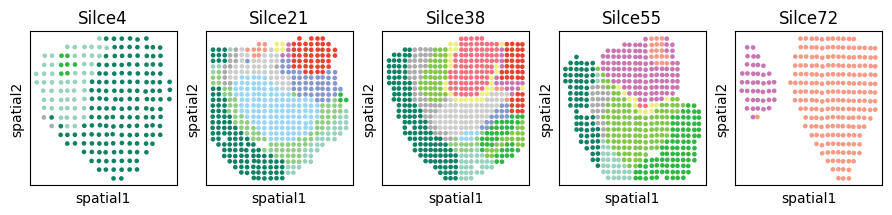

In [10]:
plt.figure(figsize=(11,2))
k=1
for i in [ 3, 20, 37, 54, 71]:
    ax = plt.subplot(1,5,k)
    sc.pl.embedding(adata_list[i], basis='spatial', color='spatial_domain', s=45, ax=ax, show=False,legend_loc=False)
    plt.title(f'Silce{i+1}')
    k+=1